In [1]:
import requests
url="https://codeforces.com/api/user.ratedList" # cf provided api
response=requests.get(url)
response_text=response.text

In [2]:
import json
data=json.loads(response_text)
handles=[u['handle'] for u in data['result'] if 'handle' in u]
handles[0:5]

['jiangly', 'Kevin114514', 'jqdai0815', 'orzdevinwang', 'tourist']

In [3]:
top_10000=handles[:10000] # number of handles to include
# currently im taking 10k
with open("handles.txt","w",encoding="utf-8") as f:
    for h in top_10000:
        f.write(h + "\n")
print("Saved",len(top_10000),"handles to handles.txt")

Saved 10000 handles to handles.txt


In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [5]:
# read in all the words
words = open('/content/handles.txt', 'r').read().splitlines()
words[:8]

['jiangly',
 'Kevin114514',
 'jqdai0815',
 'orzdevinwang',
 'tourist',
 'ecnerwala',
 'Benq',
 'ksun48']

In [6]:
len(words)

10000

In [7]:
# build the vocabulary of characters and mappins to/from integers
# Including lowercase, uppercase, numbers, and special symbols allowed in Codeforces usernames
import string
chars = sorted(list(set(''.join(words) + string.ascii_uppercase + string.digits + '_-'))) # Added uppercase, digits, underscore, and hyphen
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 # Keep '.' as the end-of-word token
itos = {i:s for s,i in stoi.items()}
vocab_size=len(itos)
print(itos)
print(vocab_size)

{1: '-', 0: '.', 3: '0', 4: '1', 5: '2', 6: '3', 7: '4', 8: '5', 9: '6', 10: '7', 11: '8', 12: '9', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'E', 18: 'F', 19: 'G', 20: 'H', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'M', 26: 'N', 27: 'O', 28: 'P', 29: 'Q', 30: 'R', 31: 'S', 32: 'T', 33: 'U', 34: 'V', 35: 'W', 36: 'X', 37: 'Y', 38: 'Z', 39: '_', 40: 'a', 41: 'b', 42: 'c', 43: 'd', 44: 'e', 45: 'f', 46: 'g', 47: 'h', 48: 'i', 49: 'j', 50: 'k', 51: 'l', 52: 'm', 53: 'n', 54: 'o', 55: 'p', 56: 'q', 57: 'r', 58: 's', 59: 't', 60: 'u', 61: 'v', 62: 'w', 63: 'x', 64: 'y', 65: 'z'}
65


In [8]:
# build the dataset
block_size=3

def build_dataset(words):
  block_size=3 # context length: how mant characters do we take to predict the next one?
  X,Y=[], []
  for w in words:
    # print(w)
    context=[0]*block_size
    for ch in w+'.':
      ix=stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context=context[1:]+[ix] # crop and append
  X=torch.tensor(X)
  Y=torch.tensor(Y)
  print(X.shape, Y.shape)
  return X,Y

import random
random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
# training split, dev/validation split, test split
# 80%, 10%, 10%

torch.Size([79347, 3]) torch.Size([79347])
torch.Size([9950, 3]) torch.Size([9950])
torch.Size([9855, 3]) torch.Size([9855])


In [9]:
# MLP revisited
n_embd=10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hiddne layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size + 1, n_embd),             generator=g) # Use updated vocab_size + 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) # kaiming init
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size + 1),          generator=g) * 0.01 # Use updated vocab_size + 1
b2 = torch.randn(vocab_size + 1,                      generator=g) * 0 # Use updated vocab_size + 1

# Batchnorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

20326


how we got the value of h (KAIMING INIT)<br>
5/3 is gain for tanh<br>
divide that with sqrt(fan-in)<br>
fan-in here for W1 is n_embd*block size

tensor(-0.0130) tensor(1.0148)
tensor(-0.0006) tensor(3.2421)


(array([6.46771872e-06, 6.46771872e-06, 0.00000000e+00, 1.29354374e-05,
        1.94031562e-05, 1.29354374e-05, 3.88063123e-05, 8.40803434e-05,
        1.29354374e-04, 3.16918217e-04, 4.13933998e-04, 7.37319934e-04,
        1.27414059e-03, 2.02439596e-03, 3.57664845e-03, 5.34880338e-03,
        8.53092099e-03, 1.37244991e-02, 2.13952135e-02, 3.14266453e-02,
        4.41939220e-02, 6.28985646e-02, 8.15449976e-02, 1.03308871e-01,
        1.20364245e-01, 1.29884727e-01, 1.32064349e-01, 1.23391138e-01,
        1.06691488e-01, 8.61435456e-02, 6.58931183e-02, 4.90770497e-02,
        3.43500541e-02, 2.33872709e-02, 1.51862036e-02, 1.00508349e-02,
        6.29309031e-03, 4.11346911e-03, 2.30897558e-03, 1.43583356e-03,
        7.82593965e-04, 4.59208029e-04, 2.58708749e-04, 1.94031562e-04,
        7.11449059e-05, 3.88063123e-05, 4.52740310e-05, 1.29354374e-05,
        0.00000000e+00, 1.94031562e-05]),
 array([-20.19341469, -19.42034458, -18.64727448, -17.87420437,
        -17.10113426, -16.3280

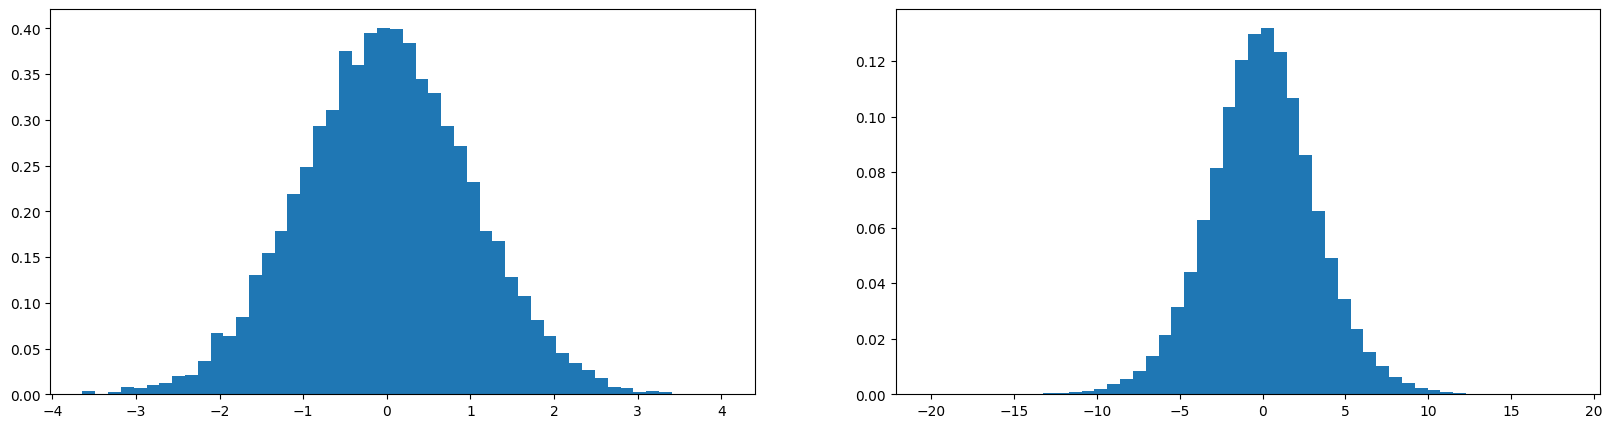

In [10]:
x_temp = torch.randn(1000, 10)
w_temp = torch.randn(10, 200)
y_temp = x_temp@w_temp
print(x_temp.mean(), x_temp.std())
print(y_temp.mean(), y_temp.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x_temp.view(-1).tolist(), 50, density =True)
plt.subplot(122)
plt.hist(y_temp.view(-1).tolist(), 50, density =True)

In [11]:
# same optimization as last time
max_steps=200000
batch_size=32
lossi=[]

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb=C[Xb] # embed the characters into vectors
  embcat=emb.view(emb.shape[0],-1) # concatenate the vectors

  # Linaer layer
  hpreact=embcat @ W1 # + b1 # hidden layer pre-activation
  # b1 commented out snce bias grad comes out to be 0 since we divide by mean later
  # also batch normalisqation has its own bias

  # BatchNorm layer
  # ------------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  # ^^ mean and std can be calculated in running manner
  hpreact = bngain * (hpreact-bnmeani)/bnstdi+ bnbias
  # batch normalisation
  with torch.no_grad():
    # running mean manner
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # 0.001 is batch size. keep it higher for higher batch size. here its small
  # ------------------------------------------------------------------

  # Non-linearity
  h=torch.tanh(hpreact) # hidden layer
  logits=h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr=0.1 if i<100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # break # see initial loss

      0/ 200000: 4.1934
  10000/ 200000: 3.2789
  20000/ 200000: 3.5805
  30000/ 200000: 3.0915
  40000/ 200000: 2.7291
  50000/ 200000: 3.1879
  60000/ 200000: 2.5336
  70000/ 200000: 2.7927
  80000/ 200000: 2.7922
  90000/ 200000: 2.6649
 100000/ 200000: 2.7857
 110000/ 200000: 3.1942
 120000/ 200000: 3.0690
 130000/ 200000: 2.8287
 140000/ 200000: 2.8265
 150000/ 200000: 3.0837
 160000/ 200000: 2.9371
 170000/ 200000: 2.8376
 180000/ 200000: 2.9450
 190000/ 200000: 3.0010


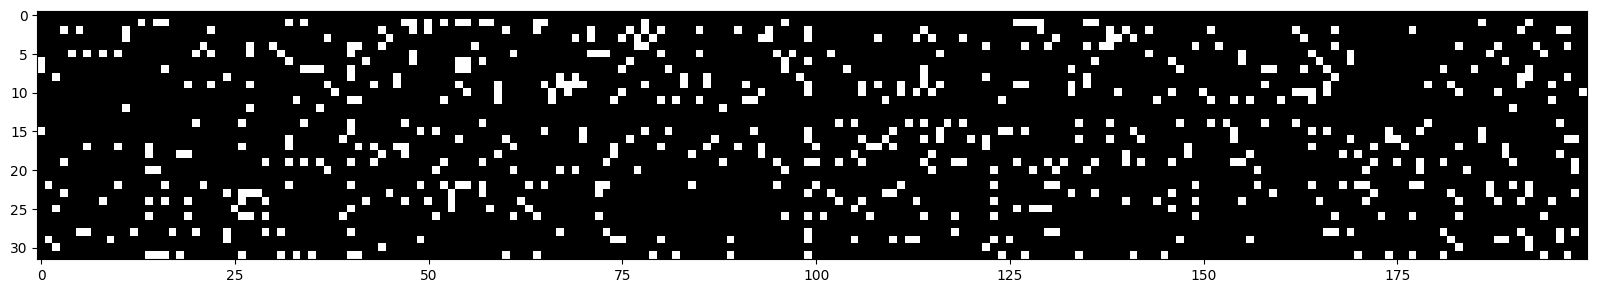

In [12]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

current h is:
torch.Size([1, 200])
we can view it as -1 to stretch it out into one large vector
then we can call tolist to convert it into one large python list of floats
MOST OF THE VALUES AREM 1 AND -1 WHICH MEANS TANH FUNCN IS VERY ACTIVE


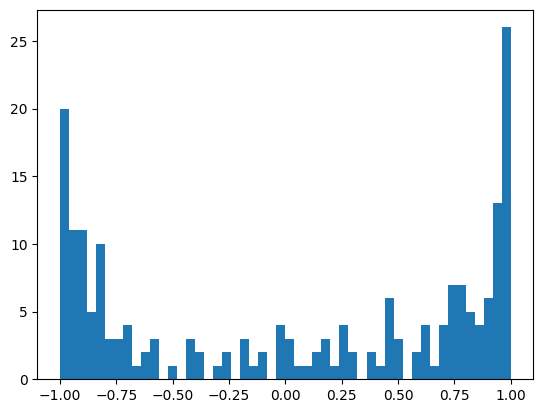

In [23]:
print("current h is:")
print(h.shape)
print("we can view it as -1 to stretch it out into one large vector\nthen we can call tolist to convert it into one large python list of floats")
temp=h.view(-1).tolist()
# print(temp)
plt.hist(temp, 50)
print("most of the values arem 1 and -1 which means tanh funcn is very active".upper());

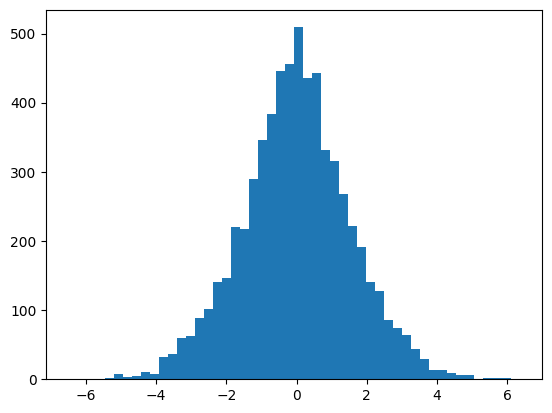

In [14]:
# plt.hist(hpreact.view(-1).tolist(),50)
plt.hist(hpreact.view(-1).tolist(),50); # semicolon removed unnecessary output

In [15]:
# at init the neural net is creating prob distributions that are all messed up
# hence loss is too high at the beginning (27)

# 4 dimensional example of this issue

def print_prob_loss(logits, message=""):
  probs=torch.softmax(logits, dim=0)
  loss = -probs[2].log()
  print(probs, loss)
  print(message)
  print()

logits=torch.tensor([0.0, 0.0, 0.0, 0.0]) # uniform distribution
# can be any numbers, doesnt have to be 0.0, just should have unif. dist.
print_prob_loss(logits, "expected loss for uniform distribution")

print_prob_loss(torch.tensor([1.0, 1.0, 1.0, 1.0]), "also uniform dist but 1 instead of 0")

print_prob_loss(torch.tensor([0.0, 0.0, 5.0, 0.0]), "correct index by chance, so very low loss by chance")

print_prob_loss(torch.tensor([5.0, 0.0, 0.0, 0.0]), "wrong index by chance, so very high loss by chance")

print_prob_loss(torch.randn(4)*10, "randomised losses")
print_prob_loss(torch.randn(4)*100, "even more extreme losses")


tensor([0.2500, 0.2500, 0.2500, 0.2500]) tensor(1.3863)
expected loss for uniform distribution

tensor([0.2500, 0.2500, 0.2500, 0.2500]) tensor(1.3863)
also uniform dist but 1 instead of 0

tensor([0.0066, 0.0066, 0.9802, 0.0066]) tensor(0.0200)
correct index by chance, so very low loss by chance

tensor([0.9802, 0.0066, 0.0066, 0.0066]) tensor(5.0200)
wrong index by chance, so very high loss by chance

tensor([7.1952e-08, 1.0400e-10, 1.0000e+00, 1.0439e-08]) tensor(1.1921e-07)
randomised losses

tensor([8.5900e-28, 0.0000e+00, 3.4422e-15, 1.0000e+00]) tensor(33.3027)
even more extreme losses



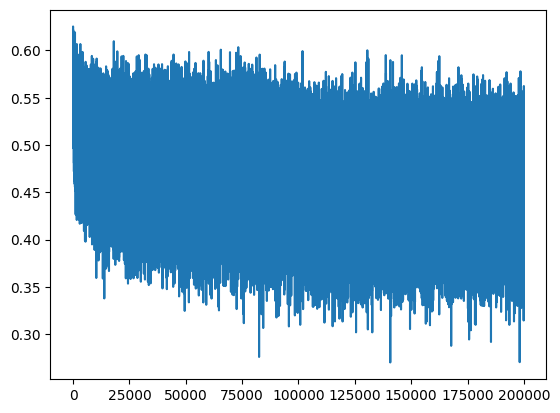

In [16]:
plt.plot(lossi)

In [17]:
# calibrate the batch norm at the end of training
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

above block isnt really going to be used<br>since now bnmean and bnmean_running are quite similar so it is preferred to use running so we dont have to expicitly calibrate at end.<br>same goes for bnstd and bnstd_running<br>


In [18]:
# tells torch that we will not call .backward() on any of these computations
# hence it doesnt need to maintain the graph under the hood
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y={
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embed)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embed)
  hpreact = embcat @ W1 # + b1
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  # this actually does something unnatural and adds jitter

  # instead of estimating it dynamically we can use bnmean and bnstd
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # + epsilon
  # we can add a very very small value of +epsilon in case the variance over our batch comes out to be 0
  # this helps prevent division by 0
  # skipped in this case because unlikely to happen

  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.785353899002075
val 3.061318874359131


## loss log
<hr>
original:<br>train 2.1245384...<br>val 2.1681964...
<hr>
fix softmax confidently wrong:<br>train 2.07<br> val 2.03
<hr>
fix tanh layer too saturated at init:<br>train 2.0355966<br>val 2.1026785
<hr>
use semi principled "kaiming init" instead of hacky init:<br>train: 2.0376641<br>val: 2.1681964
<hr>
add a batch norm layer<br>train: 2.0668270<br>val: 2.1048448

In [21]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size # initialize with all ...
  while True:
    # forward pass the neural net
    emb = C[torch.tensor([context])] # (1,block_size,d)
    hpreact = emb.view(1, -1) @ W1 # + b1 # apply batch norm
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2
    probs=F.softmax(logits, dim=1)
    # sample from the distribution
    ix= torch.multinomial(probs, num_samples=1, generator=g).item()
    # shift the context window and track the samples
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample the special '.' token, break
    if ix == 0:
      break
  print(''.join(itos[i] for i in out)[:-1]) # decode and print the generated word

Beop
dhexhsj
Magnfank
Kirut0larami7it2
codskieko
Lin
ding
cpy
sokhuatPimc204
Res
To12
Xue
Nartflylett
Huicbividel_S
kr
Staress1
Sadamoochaiber
_NaQFUU
breage1646
siz


okay